In [58]:
#-configuration---------
transmissions = 0.1:0.05:0.9
temp = 1e-7
integration = (-15.0, 15.0)
voltage = (0.05, 0.01, 6.00)
#-----------------------
;

In [59]:
#-checks----------------
if temp <= 0
    println("Temperature is 0.\n Assuming default value of 1e-7")
    temp = 1e-7
end

@assert voltage[1] >= 0.005 "Voltage must be greater or equal to 0.005"
#----------------------

In [60]:
#-dependencies----------
using ProgressMeter
using Plots
using JLD2
#----------------------

In [61]:
#-Constants------------
const G₀ = 7.748091729e-5
const e = 1.602176634e-19
const h = 6.62607015e-34
#----------------------
;

In [62]:
# convert input parameters
transmissions = collect(transmissions)
voltages = collect(voltage)

# find working dirs
start_dir = @__DIR__
temp_dir = joinpath(@__DIR__, "..", "temp")
bin_dir = joinpath(@__DIR__, "..", "bin")
plots_dir = joinpath(@__DIR__, "..", "plots")
data_dir = joinpath(@__DIR__, "..", "data")
;

In [63]:
cd(temp_dir)
for i in 1:Threads.nthreads()
   run(`mkdir -p thread_$i`)
   run(`cp $bin_dir/iv $temp_dir/thread_$i`)
   open(joinpath(temp_dir,"thread_$i", "do.sh"), "w") do file
      write(file, "cat temp_config.txt | ./iv")
   end
end

In [ ]:
# curve dictionary [τ] = (x, y)
curves = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
cache = Vector{Tuple{Vector{Float64},Vector{Float64}}}(undef, length(transmissions))

progress = Progress(length(transmissions), 1, "Running simulations")
for i in 1:lastindex(transmissions)
    t = transmissions[i]

    dir_num = mod(i - 1, Threads.nthreads()) + 1
    thread_dir = joinpath(temp_dir, "thread_$(dir_num)")

    run(`rm -f $(joinpath(thread_dir, "iv.dat"))`)
    run(`rm -f $(joinpath(thread_dir, "temp_config.txt"))`)

    open(joinpath(thread_dir, "temp_config.txt"), "w") do file
        write(file, "  $t  $temp\n")
        write(file, "$(integration[1])  $(integration[2])\n")
        write(file, "  $(voltage[1])  $(voltage[3])  $(voltage[2])\n")
    end

    run(`chmod +x $(joinpath(thread_dir, "do.sh"))`)
    run(`bash -c "cd $(thread_dir) && $(joinpath(thread_dir,"do.sh"))"`)

    x = []
    y = []

    open(joinpath(thread_dir, "iv.dat"), "r") do file
        data = read(file, String)
        lines = split(data, "\n")
        filter!(x -> x != "", lines)
        for line in lines
            d = line
            line = strip(line, ['\0', ' '])
            parts = split(line, ' ')
            filter!(x -> x != "", parts)
            try
                push!(x, parse(Float64, parts[1]))
                push!(y, parse(Float64, parts[2]))
            catch e
                println("Error parsing line: '$d', in file: $(joinpath(thread_dir, "iv.dat"))")
                rethrow(e)
            end
        end
    end
    cache[i] = (x, y)

    next!(progress)
end

for (i,t) in enumerate(transmissions)
    curves[t] = cache[i]
end

const raw = copy(curves);

Assigning transmission: 0.8 to index 15
Assigning transmission: 0.5 to index 9
Assigning transmission: 0.1 to index 1
Assigning transmission: 0.6 to index 11
Assigning transmission: 0.4 to index 7
Assigning transmission: 0.9 to index 17
Assigning transmission: 0.7 to index 13
Assigning transmission: 0.3 to index 5
Assigning transmission: 0.2 to index 3
Assigning transmission: 0.85 to index 16


Running simulations  12%|███▊                            |  ETA: 0:02:07

Assigning transmission: 0.45 to index 8


Running simulations  18%|█████▋                          |  ETA: 0:01:26

Assigning transmission: 0.65 to index 12
Assigning transmission: 0.25 to index 4


Running simulations  29%|█████████▍                      |  ETA: 0:00:53

Assigning transmission: 0.75 to index 14
Assigning transmission: 0.15 to index 2
Assigning transmission: 0.35 to index 6


Running simulations  59%|██████████████████▉             |  ETA: 0:00:17

Assigning transmission: 0.55 to index 10


Running simulations 100%|████████████████████████████████| Time: 0:00:42


In [65]:
curve_processed = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
for (τ, curve) in curves
    x, y = curve
    x = copy(x)
    y = copy(y)
    G = G₀ * τ
    y .*= (2*e^2 / h)
    y ./= G
    curve_processed[τ] = (x, y)
end
const normalized = copy(curve_processed);

In [79]:
normalized = curves;

In [80]:
curve_derived = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
for (τ, curve) in curve_processed
    x, y = curve
    y = diff(y) ./ diff(x)
    x = x[1:end-1]
    curve_derived[τ] = (x, y)
end
const derived = copy(curve_derived);

In [81]:
jldopen(joinpath(data_dir, "iv.jld2"), "w") do file
    file["raw"] = raw
    file["normalized"] = normalized
    file["derived"] = derived
end;

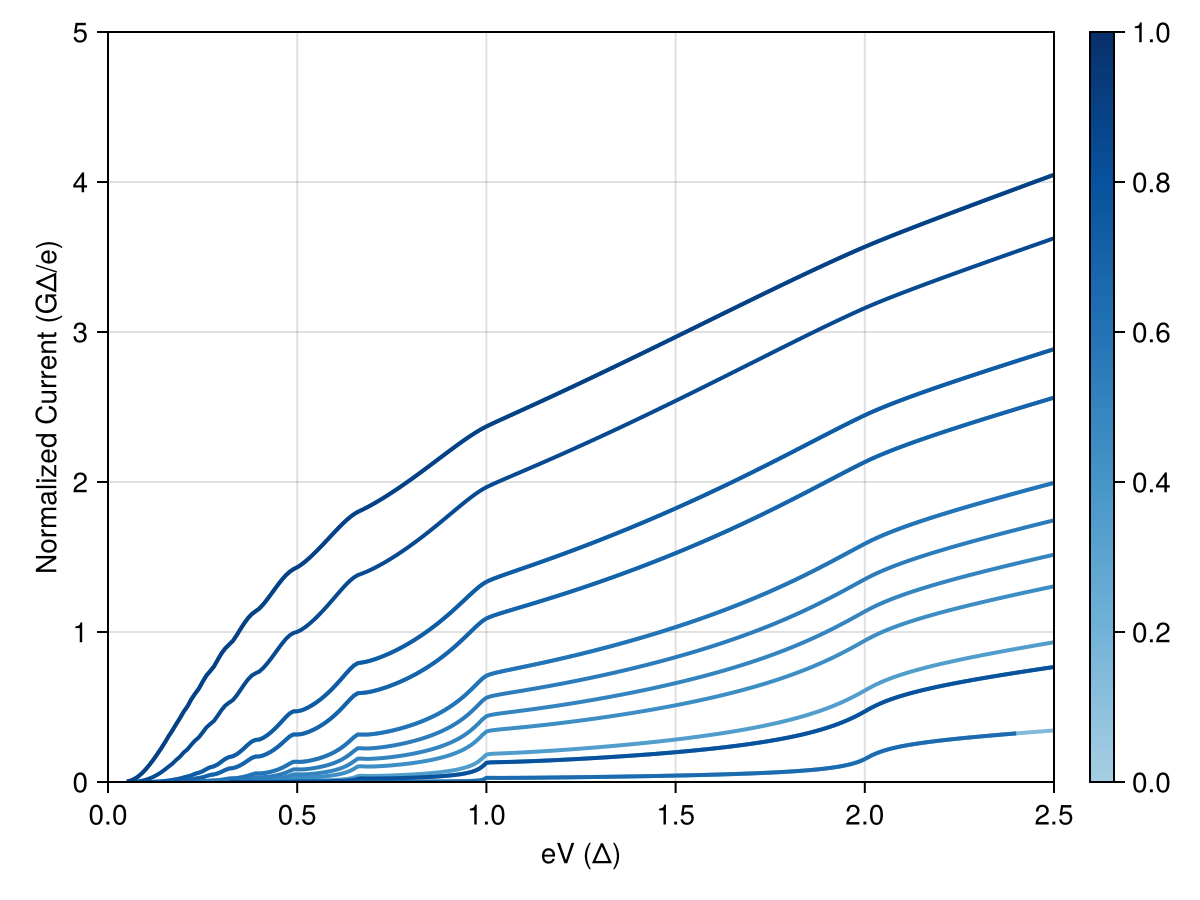

CairoMakie.Screen{SVG}


In [82]:
using CairoMakie
using ColorSchemes

t_values = sort(collect(keys(normalized)))

max_clip = 1.0  
min_clip = 0.35

clip_normalize(t, min_val, max_val) = t_rel = min_val + t * (max_val - min_val)

see = get(ColorSchemes.Blues, range(min_clip, max_clip, length=256))

fig = Figure()
ax = Axis(fig[1, 1])

for (i, t) in enumerate(t_values)
    x, y = normalized[t]
    color_idx = clip_normalize(t, min_clip, max_clip)
    lines!(ax, x, y, color=cgrad(:Blues)[color_idx], linewidth=2)
end
ax.xlabel = "eV (Δ)"
ax.ylabel = "Normalized Current (GΔ/e)"
ax.limits = (0, 2.5), (0, 5)

Colorbar(fig[1, 2], colormap=see, ticks=0:0.2:1)

display(fig)
save(joinpath(plots_dir, "iv2.svg"), fig)

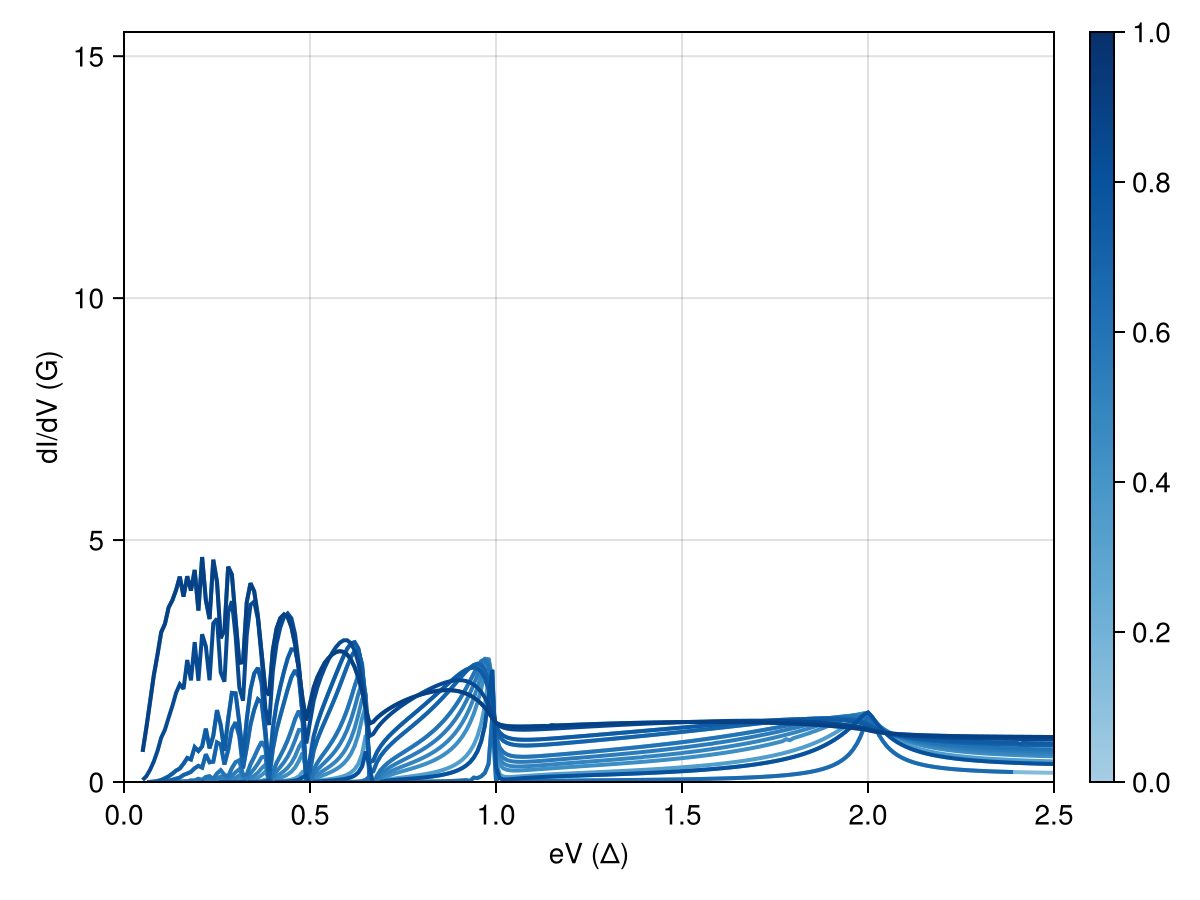

CairoMakie.Screen{SVG}


In [83]:
fig = Figure()
ax = Axis(fig[1, 1])

for (i, t) in enumerate(t_values)
    x, y = derived[t]
    color_idx = clip_normalize(t, min_clip, max_clip)
    lines!(ax, x, y, color=cgrad(:Blues)[color_idx], linewidth=2)
end
ax.xlabel = "eV (Δ)"
ax.ylabel = "dI/dV (G)"
ax.limits = (0, 2.5), (0, 15.5)

Colorbar(fig[1, 2], colormap=see, ticks=0:0.2:1)
display(fig)
save(joinpath(plots_dir, "didv.svg"), fig)